# Linear Regression Analysis and Prediction for IoT

GitHub link: https://github.com/psenrique/AAI530_ASSIGNMENT3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
import datetime as dt
from sklearn.metrics import mean_squared_error as mse

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv('AAI530_ASSIGNMENT2_DATA.csv')

In [4]:
#convert datetime to epoch/unix time
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['unix'] = (df['Datetime'] - dt.datetime(1970,1,1)).dt.total_seconds()

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is the predictive horizon or how far out the predictions are being made, and mu is the forgetting factor which exponentially decays the data from the history.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [18]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 60*5 #5 minutes
ph_index = round(ph/10) #ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: $0.9^{4999}$, Essentially a negligible weight

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [19]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

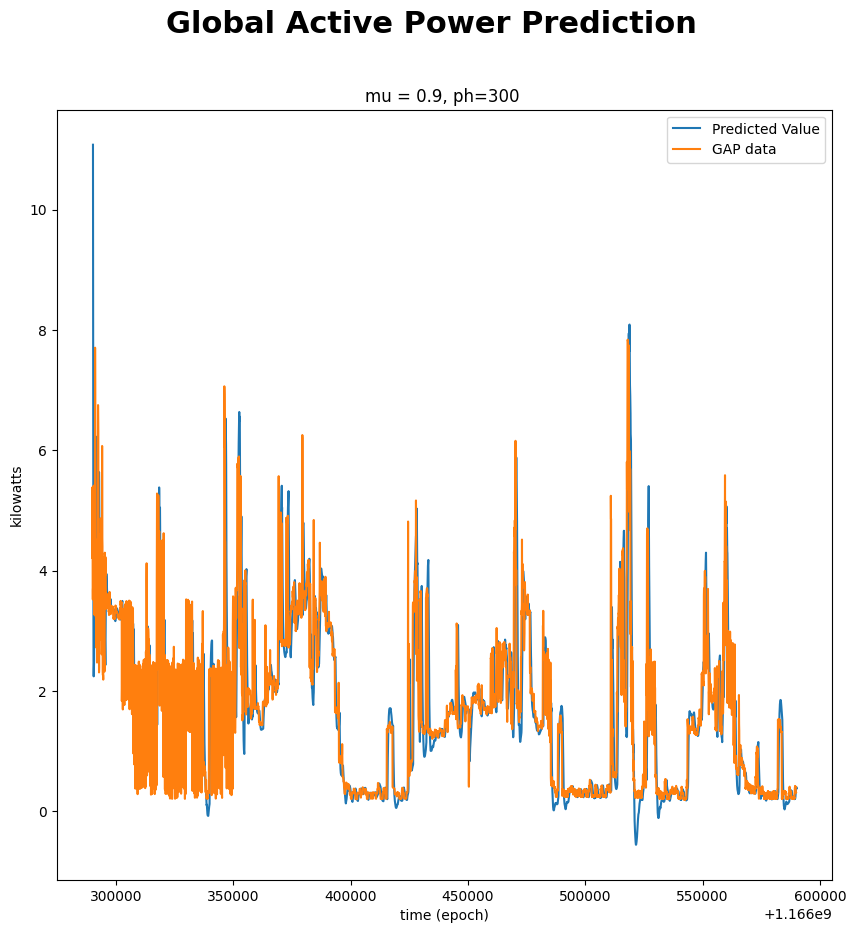

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

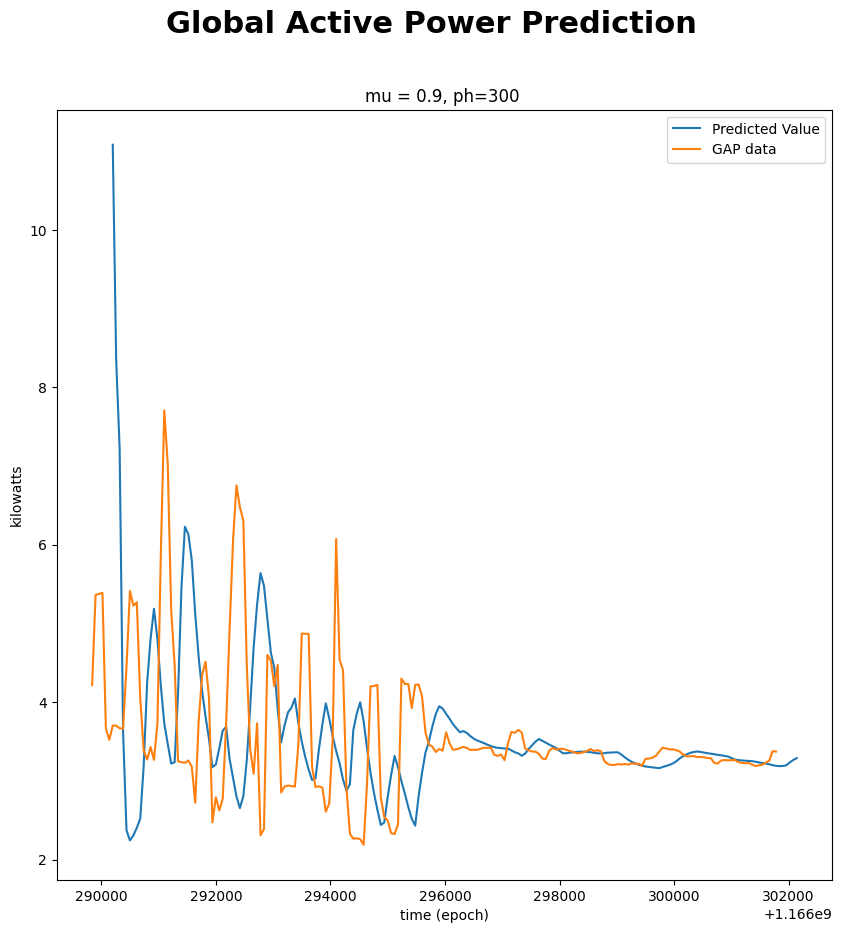

In [9]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

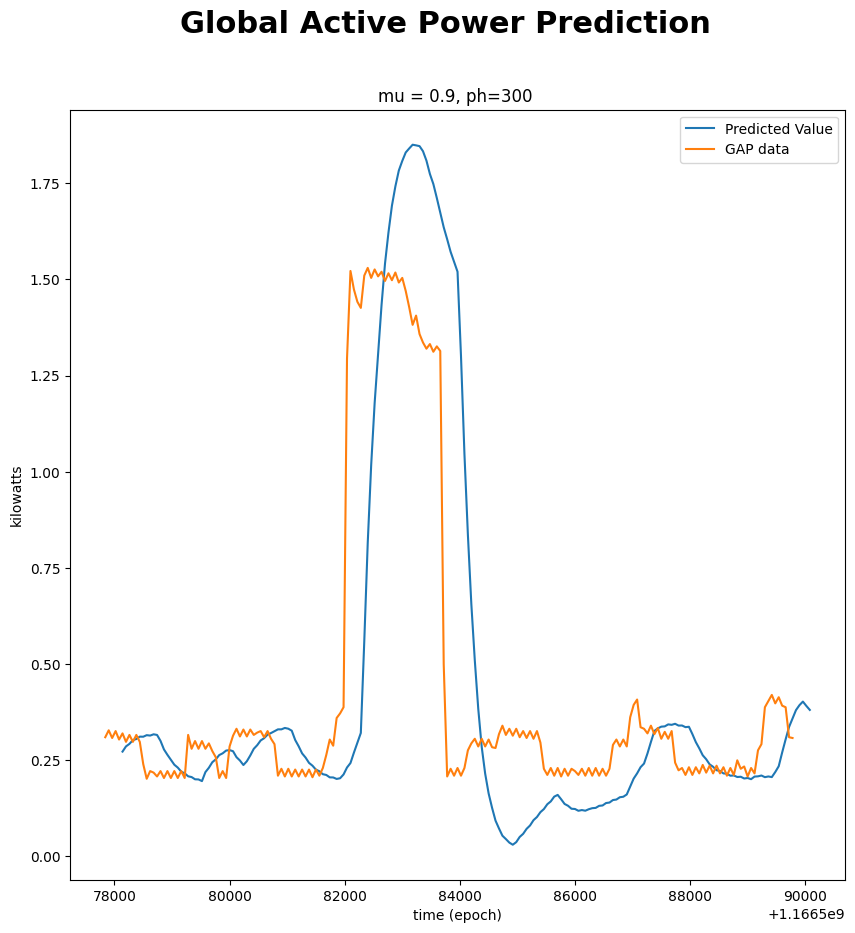

In [10]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [11]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3813092257797268


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: From the graphs it can be seen that there is a delay in the predictions and the details of the true curve are smoothed out and not captured in the prediction. The early predictions are underestimating the highs and lows of the values while the late predictions are overshooting the highs and lows. The MSE value is very close to 0 indicating that the predictions are close to the true data points and that the model is doing a good job of predicting the global active power.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

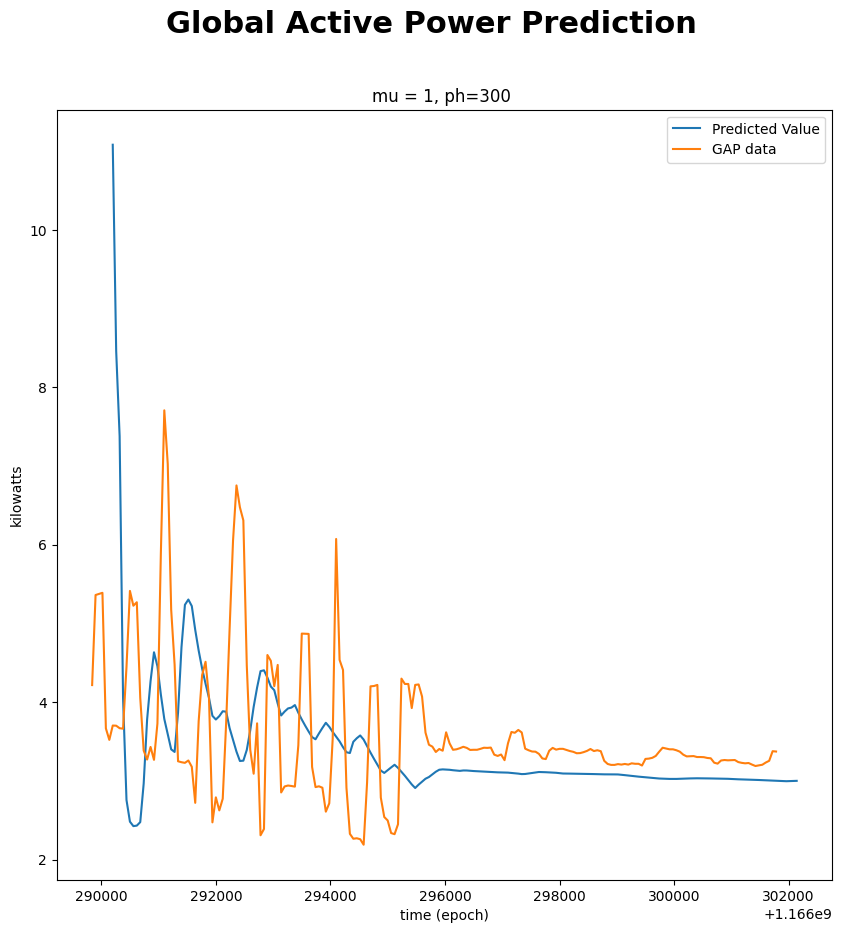

In [14]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

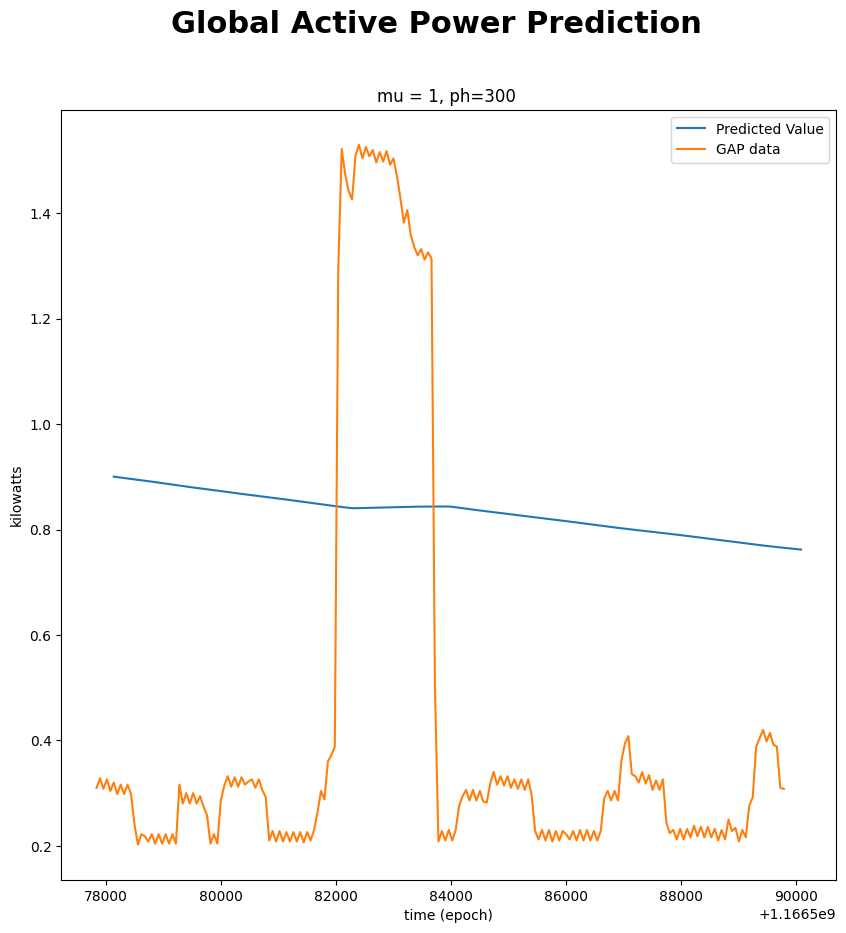

In [15]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [17]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.5015879165294963


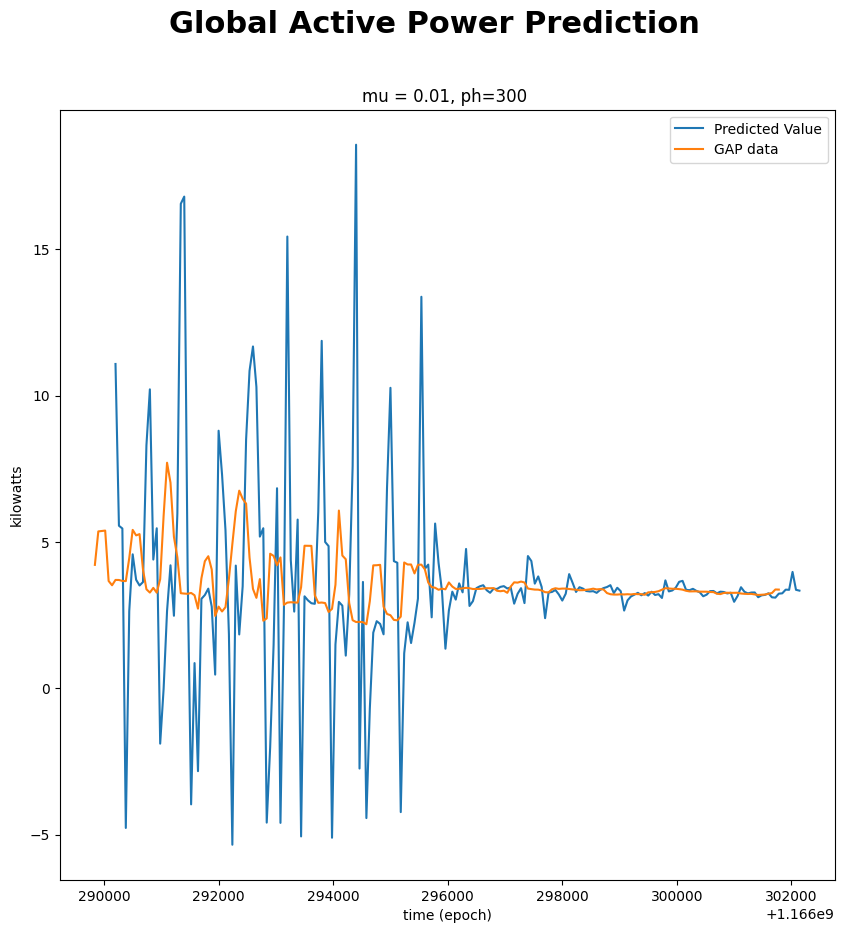

In [20]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

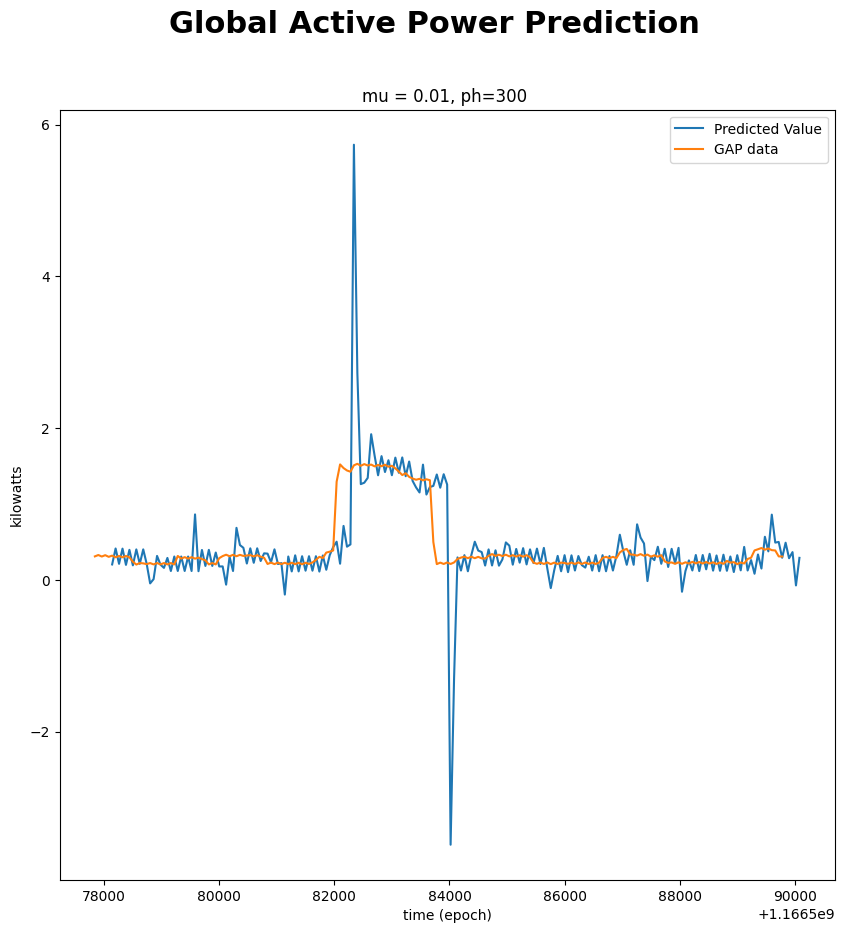

In [21]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [22]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 8.625382956038793


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The predictive model with mu=1 starts decent by following the true curve but quickly flatlines and no longer is accurate. The MSE is higher than the model with mu=0.9 indicating a decline in performance which is confirmed by the graphs

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model with mu=0.01 stays consistent between the early and late predictions; however, it is drastically overshooting the peaks and valleys in the curves. The MSE value is about 6 times higher than the previous two models indicating this is not the best model for predicting the global average power.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: Based on the MSE values calculated, the best model is the first one with a mu=0.9. This is reasonable as the mu values ensures that old values are not significantly affecting the current prediction while still maintaining enough historical values to make an up to date prediction.  

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: An improvement can be to change the predictive horizon to better suit the intended use of the data. Since the data appears to change rapidly, a shorter predictive horizon can result in less error and more accurate predictions. Also, better predictions may be made if a monthly average of the data was taken.  

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [23]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df[['unix','Voltage']])
ys = pd.DataFrame(df.Global_active_power)
ts['Voltage'] = ts['Voltage']*1000 #account for units (kW v.s V)

ph = 60*5 #5 minutes
ph_index = round(ph/10)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [24]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    vp = ts.iloc[i-1,1] + ph
    yp = m_tmp[0,0]*tp + m_tmp[0,1]*vp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

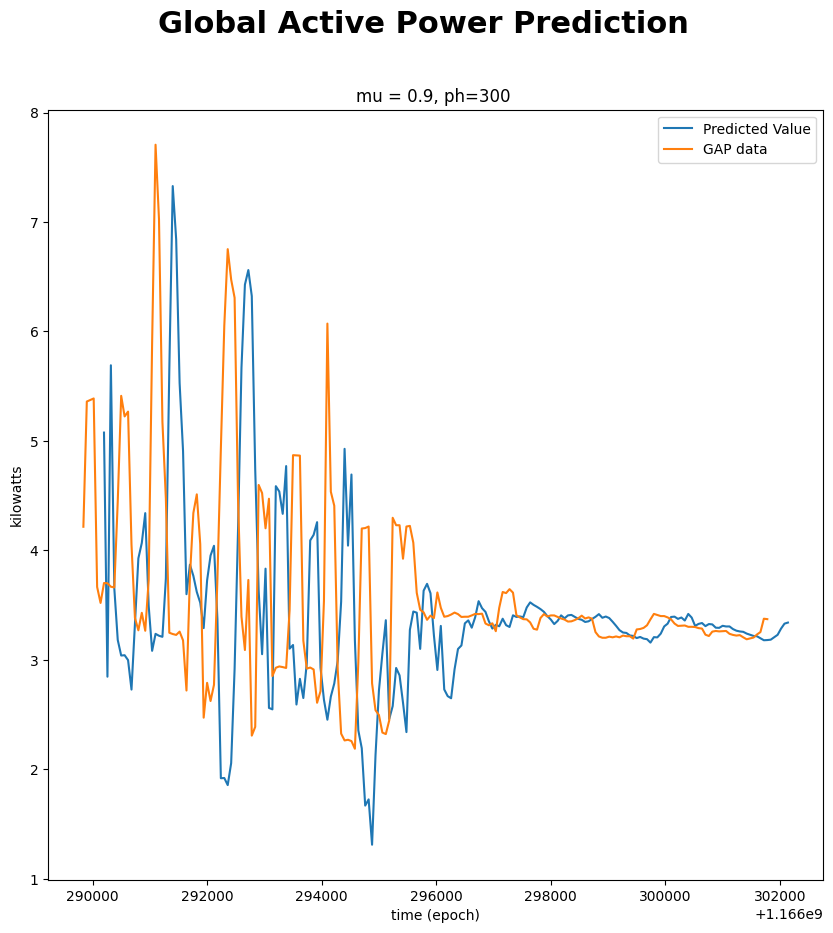

In [25]:
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

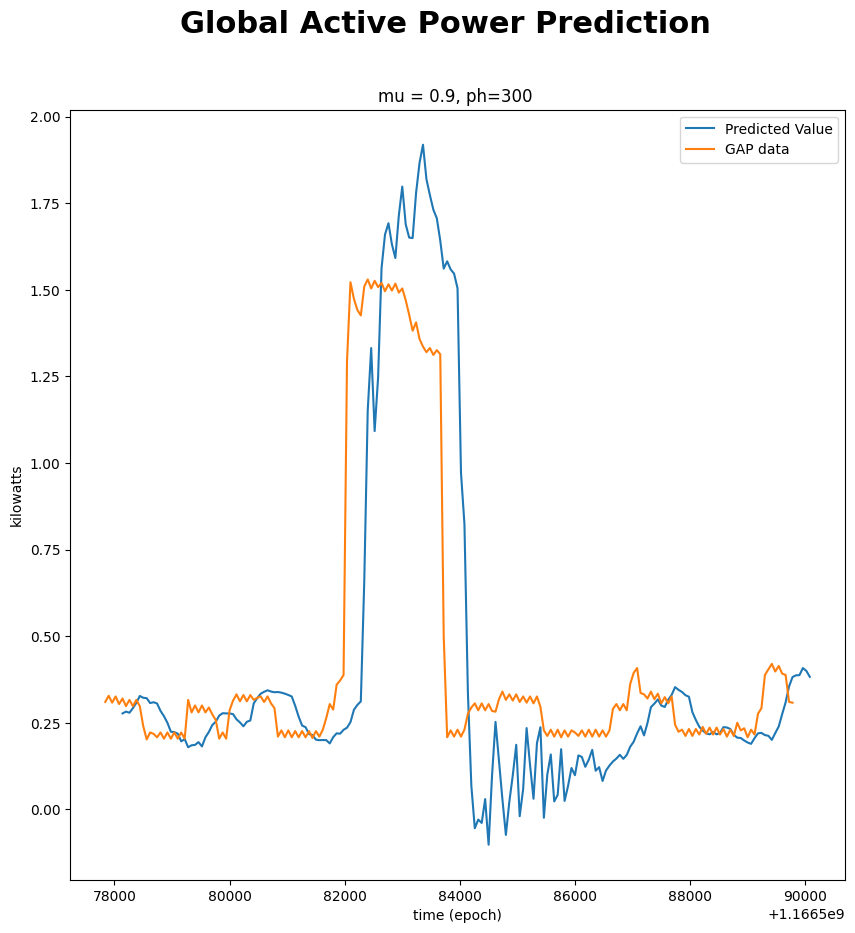

In [26]:
#Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [27]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3458547947638404


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model with the added voltage variable performed similarly to that without the voltage and a mu=0.9. The MSE were 1.38 for the original model and 1.34 for the model with the voltage which is an improvement but not very significant. From the graphs it can be seen that the late predictions are still being overshot and the fine details of the curve are being missed.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: Using a 30 day moving average will remove some of the noise from the data and make the data trend more evident, thus making it easier to predict.

In [29]:
#create your alternative training data here
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)
time_30 = 30*24*60 #30 day moving average taking time units(s) into account
ys = ys.rolling(time_30).mean() #take rooling average over 30 days
ys = ys.dropna() #remove initial values that are Nan

ph = 60*5 #5 minutes
ph_index = round(ph/10)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [30]:
#re-run the prediction code here
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

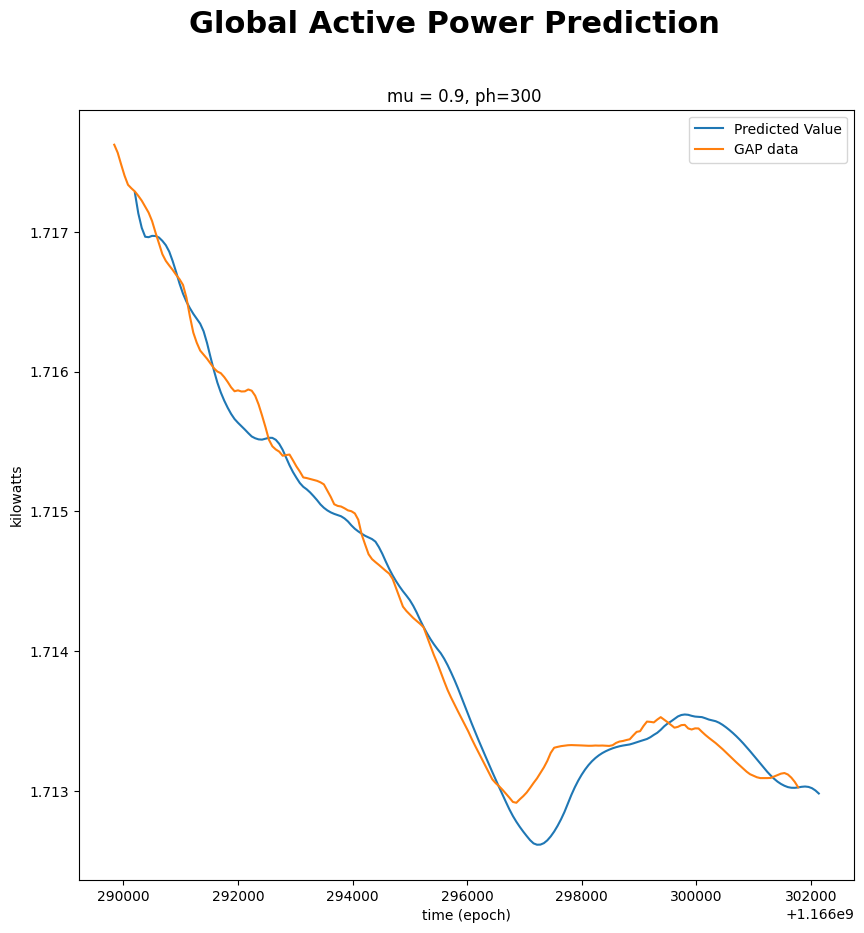

In [31]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

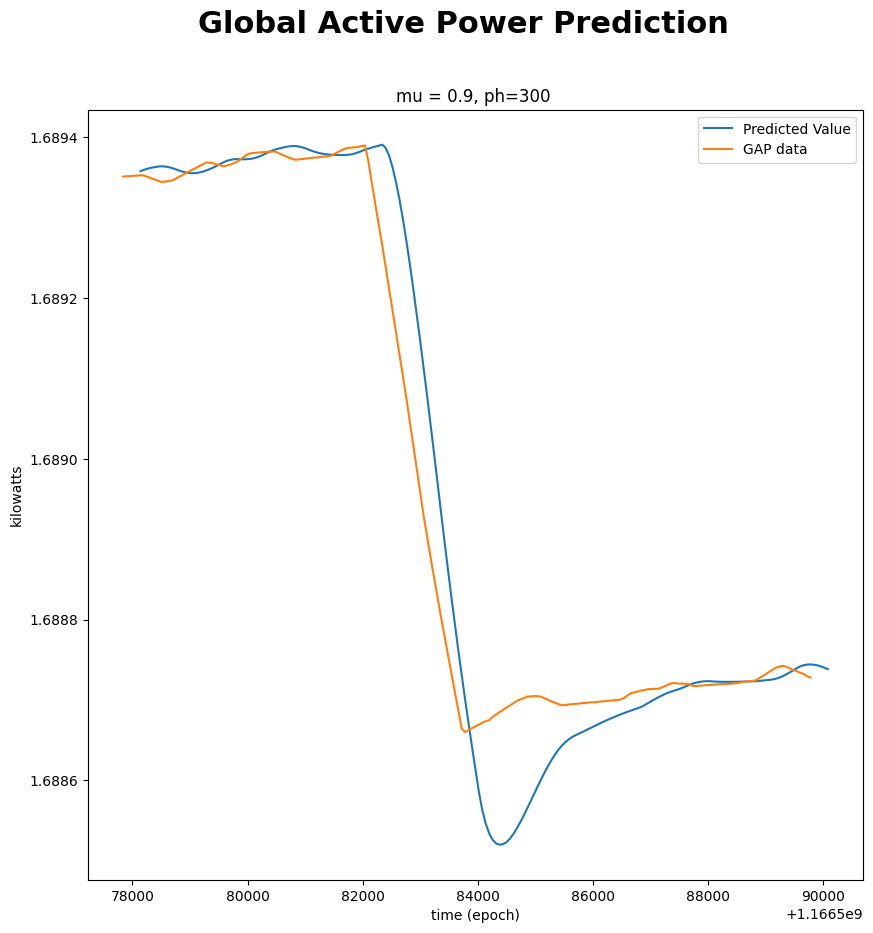

In [32]:
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [33]:
#Calculate MSE of predictions for alternative model
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 5.652646950969752e-07


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: Both the graphs and the MSE value indicate that the moving average approach improved from the previous results.  The MSE value is dramatically smaller than any of the other models and the graphs only show overshooting on the valleys as opposed to the peaks and valleys. To improve the moving average, the 30 day average can be reduced to avoid simplifying the trend too much while ensuring the model is still able to make accurate predictions. Other improvements to consider include, other variables aside from voltage being used for a multiple linear regression model and an exploration on the optimal mu value.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.